### Profiling Customer groups for Segmentation

The data provided contains information on customers purchasing and useage behavior with the telecom products. 

In [2]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
# Read the CSV file into a DataFrame
df = pd.read_csv('data/telco_churn_data.csv')

# Display the first 5 rows
print(df.head().to_markdown(index=False, numalign="left", stralign="center"))

|  Customer ID  |  Referred a Friend  | Number of Referrals   | Tenure in Months   |  Offer  |  Phone Service  | Avg Monthly Long Distance Charges   |  Multiple Lines  |  Internet Service  |  Internet Type  | Avg Monthly GB Download   |  Online Security  |  Online Backup  |  Device Protection Plan  |  Premium Tech Support  |  Streaming TV  |  Streaming Movies  |  Streaming Music  |  Unlimited Data  |    Contract    |  Paperless Billing  |  Payment Method  | Monthly Charge   | Total Regular Charges   | Total Refunds   | Total Extra Data Charges   | Total Long Distance Charges   |  Gender  | Age   |  Under 30  |  Senior Citizen  |  Married  |  Dependents  | Number of Dependents   |    City     | Zip Code   | Latitude   | Longitude   | Population   | Churn Value   | CLTV   |  Churn Category  |         Churn Reason         | Total Customer Svc Requests   | Product/Service Issues Reported   | Customer Satisfaction   |
|:-------------:|:-------------------:|:----------------------|:---------

In [4]:
# Print the column names and their data types
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 46 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Referred a Friend                  7043 non-null   object 
 2   Number of Referrals                7043 non-null   int64  
 3   Tenure in Months                   7043 non-null   int64  
 4   Offer                              3166 non-null   object 
 5   Phone Service                      7043 non-null   object 
 6   Avg Monthly Long Distance Charges  7043 non-null   float64
 7   Multiple Lines                     7043 non-null   object 
 8   Internet Service                   7043 non-null   object 
 9   Internet Type                      5517 non-null   object 
 10  Avg Monthly GB Download            7043 non-null   int64  
 11  Online Security                    7043 non-null   objec

The data contain information about customer demographics, service usage, charges, and a churn indicator. Many of the columns are already in a numeric format, which is suitable for PCA.

## Columns to drop


  We are  we will exclude these from the clustering analysis.

  - '**Customer ID**' (irrelevant to consideration here)
  - '**Referred a Friend**' : already captured in 'Number of referrals'
  - '**Under 30**' and '**Senior Citizen**' : already captued by 'Age'
  - '**City**', '**Lat.**' , '**Long.**', '**Zip Code**', '**Population**' - proximity is ignored for this iteration
  - '**Dependents**' : 'Number of Dependents' :  captures this data
  - '**Offer**, '**Internet Type**', '**Churn Reason**', '**Churn Category**', **Customer Satisfaction** : too many NaN values
  - Given that the columns '**Churn Value**' and '**CLTV**' appear to be related to the customer's value and likelihood to churn.

In [7]:
# Drop the selected columns 
cols_to_drop = ['Customer ID', 'Referred a Friend', 'Under 30', \
                'Senior Citizen', 'City', 'Latitude' , 'Longitude', \
                'Zip Code', 'Population', \
                'Dependents', 'Offer', 'Internet Type', 'Churn Reason', \
                'Churn Category', 'Customer Satisfaction', \
                'Churn Value','CLTV', ]
df_pca_cluster = df.drop(cols_to_drop, axis = 1)

We will convert the remaining object columns to numeric using one-hot encoding. Then, we will standardize the data and apply PCA to reduce dimensionality. Finally, we will use K-Means clustering to segment the customers.

Given that the data appears to be on the customer-level, and we are looking to segment customers into groups, we will not be using any sampling methods.

In [9]:
# Get all object columns
obj_cols = df_pca_cluster.select_dtypes(include='object').columns

### OneHotEncoder

Drop the first category in each feature - keep the varaince by including k-1 columns for k categories.

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html" target="_blank">sci-kit-learn OneHotEncoder</a>

In [11]:
# One-hot encode the object columns
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_data = encoder.fit_transform(df_pca_cluster[obj_cols])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(obj_cols))

In [12]:
# Drop the original object columns and append the encoded columns
df_pca_cluster = df_pca_cluster.drop(columns=obj_cols)
df_pca_cluster = pd.concat([df_pca_cluster, encoded_df], axis=1)

### Standardize the data and apply PCA to reduce dimensionality.

In [14]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_pca_cluster)

In [15]:
# Apply PCA to get explained variance ratios for all components
pca_all = PCA()
pca_all.fit(scaled_data)

PCA()

In [16]:
pca_all.explained_variance_ratio_.round(2)

array([0.2 , 0.1 , 0.07, 0.05, 0.05, 0.04, 0.04, 0.04, 0.04, 0.03, 0.03,
       0.03, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  ])

In [17]:
# Create a DataFrame for the scree plot
scree_data_all = pd.DataFrame({'Principal Component': range(1, len(pca_all.explained_variance_ratio_) + 1),
                          'Explained Variance Ratio': pca_all.explained_variance_ratio_})

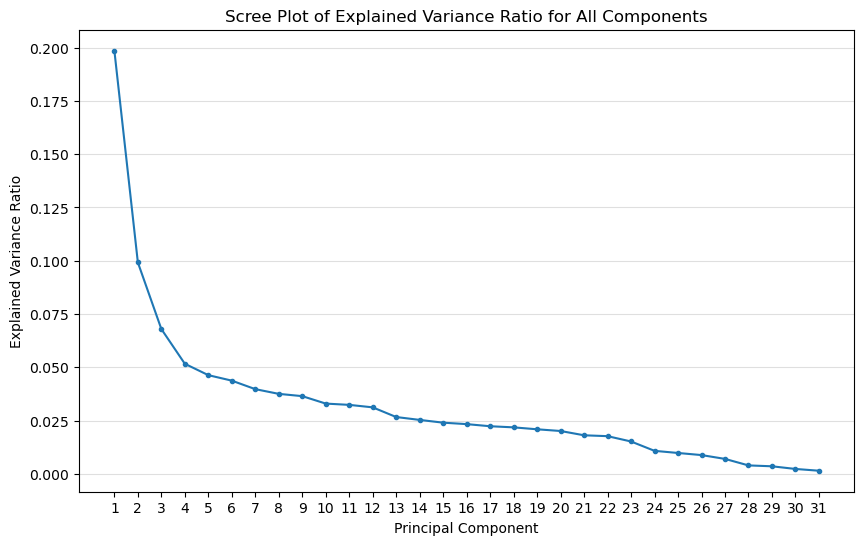

In [18]:
# Create the scree plot
plt.figure(figsize=(10, 6))
plt.plot(scree_data_all['Principal Component'], scree_data_all['Explained Variance Ratio'], marker='.')
plt.title('Scree Plot of Explained Variance Ratio for All Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(scree_data_all['Principal Component'])
plt.grid(axis='y', alpha=0.4)
plt.savefig('images/scree_plot.png')
plt.show()

## Interpretation of PCA and rationale for choosing number of components

While the scree plot helps visualize the explained variance for each principal component, it doesn't provide a definitive answer for the number of components to choose. We will calculate the cumulative explained variance for each principal component and determine the number of components needed to explain at least 95% of the variance.

While **23** principal components are needed to explain **95%** of the variance, only 2 principal components were chosen for the clustering analysis to simplify the interpretation and visualization of the results.

Using only two components allows for easy plotting and understanding of the clusters in a two-dimensional space. While this simplification may result in some loss of information, it prioritizes interpretability, which is important for practical applications of customer segmentation.

The scree plot also supports this decision, as it shows a significant drop in explained variance after the first two components, suggesting that the remaining components contribute less to explaining the overall variability in the data.

In [20]:
# Apply PCA to reduce the number of dimensions to 3
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

### Use K-Means clustering to segment the customers

In [22]:
# Find the optimal number of clusters using the elbow method
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init = 10, random_state=42)
    kmeans.fit(pca_result)
    inertia.append(kmeans.inertia_)

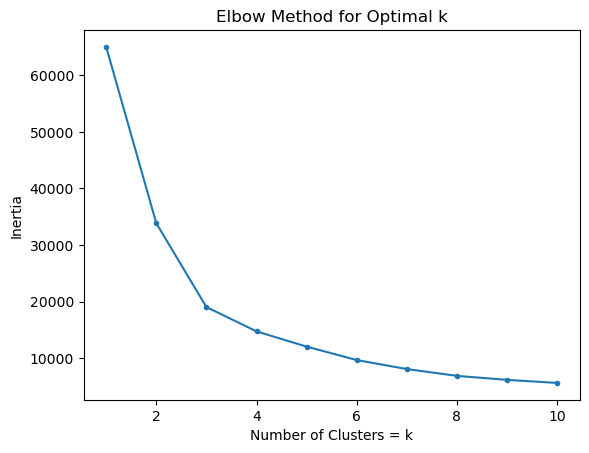

In [23]:
# Plot the elbow method graph
plt.plot(range(1, 11), inertia, marker='.')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters = k')
plt.ylabel('Inertia')
plt.savefig('images/elbow_chart.png')
plt.show();

The elbow method plot provides a visual way to assess the optimal number of clusters. The plot shows a bend or **elbow** at k=3, where the rate of decrease in inertia starts to slow down. This suggests that adding more clusters beyond 3 does not significantly improve the compactness of the clusters.

In [25]:
# Apply K-means clustering with the optimal number of clusters
optimal_k = 3
kmeans = KMeans(
    n_clusters=optimal_k, 
    n_init = 10, # To get rid of a pesky future warning
    random_state=42
)
cluster_labels = kmeans.fit_predict(pca_result)

In [26]:
# Add the cluster labels back to the original dataframe
df_pca_cluster['Cluster'] = cluster_labels

In [27]:
# Aggregate by cluster and calculate the mean for each column
cluster_means = df_pca_cluster.groupby('Cluster').mean().round(2)

Here's a summary of the average characteristics of each cluster:

In [29]:
# Print the results
print(cluster_means.to_markdown(numalign="center", stralign="center"))

|  Cluster  |  Number of Referrals  |  Tenure in Months  |  Avg Monthly Long Distance Charges  |  Avg Monthly GB Download  |  Monthly Charge  |  Total Regular Charges  |  Total Refunds  |  Total Extra Data Charges  |  Total Long Distance Charges  |  Age  |  Number of Dependents  |  Total Customer Svc Requests  |  Product/Service Issues Reported  |  Phone Service_Yes  |  Multiple Lines_Yes  |  Internet Service_Yes  |  Online Security_Yes  |  Online Backup_Yes  |  Device Protection Plan_Yes  |  Premium Tech Support_Yes  |  Streaming TV_Yes  |  Streaming Movies_Yes  |  Streaming Music_Yes  |  Unlimited Data_Yes  |  Contract_One Year  |  Contract_Two Year  |  Paperless Billing_Yes  |  Payment Method_Credit Card  |  Payment Method_Mailed Check  |  Gender_Male  |  Married_Yes  |
|:---------:|:---------------------:|:------------------:|:-----------------------------------:|:-------------------------:|:----------------:|:-----------------------:|:---------------:|:--------------------------:|

In [30]:
# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'x': pca_result[:, 0],
    'y': pca_result[:, 1],
    'Cluster': cluster_labels.astype(str)  # Convert cluster labels to strings for color encoding
})

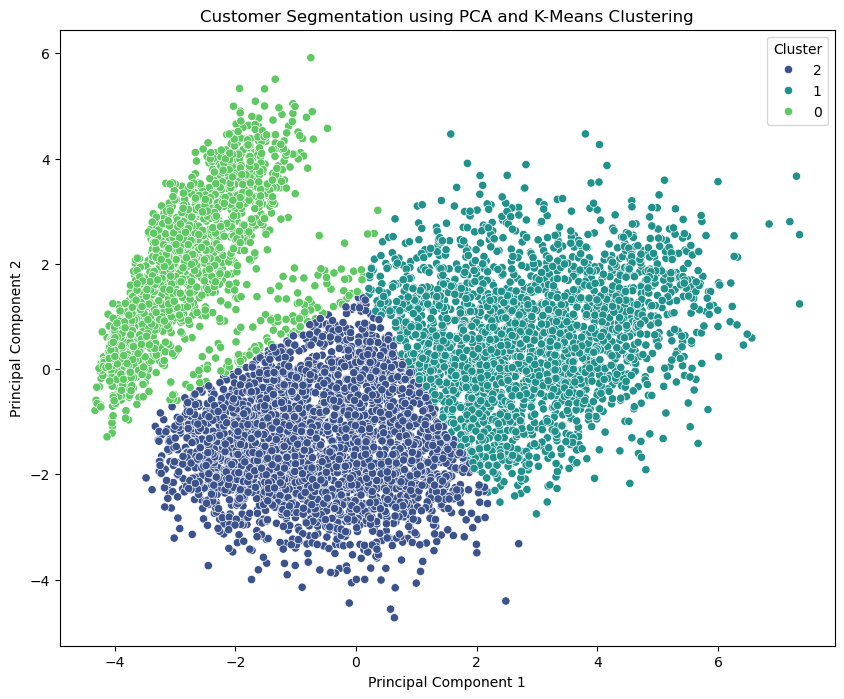

In [31]:
# Create a scatter plot using Seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(data=plot_df, x='x', y='y', hue='Cluster', palette='viridis')
plt.title('Customer Segmentation using PCA and K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.savefig('images/Customer_Segmentation.png')
plt.show();

### Cluster 0: Basic Profile

This customer persona is typically a low-spender and is looking for essential services with value. They have an average tenure of 30 months and an average monthly bill of $23. They eschew higher-value add-on features such as Internet, Data, Streaming content, or multiple lines of service. They are on contract more likely than not at 64%. 

### Cluster 1: Long Tenured, Premium Features and Spending.

This customer is typically married, has a tenure of 55 months on average, and has the highest monthly bill at $90. They will likely have subscribed to streaming services, premium support, and multiple lines. They are also most likely to have 1- or 2- year contracts. 

### Cluster 2: High Propensity Customer

This customer is typically a single person, has the lowest tenure amongst the 3 clusters, and is likelier to have a month-to-month plan. They have a higher monthly bill than the basic customer, have an Internet plan, and are voracious Data Users. They also have the highest service issues among the 3 clusters.
  


## Summary

<p> 
These revised clusters accurately represent the customer segments within the telecom company's customer base. The company could use this information to tailor marketing strategies, customer service approaches, or product offerings to meet each segment's needs better.
</p>

